## Intro

In this Notebook I will train and evaluate two different Trigram models.
More precisely I will use two different approaches for creating a Trigram model.
Approach 1 is to build a matrix that holds the true probability distribution of which character 
comes next given that the model has been given two particular preceeding characters.
We then sample from this distribution to produce the next character in the output 'name'.

The second approach is to use a Neural Net. We take in the two preceeding characters to generate the next one 
and so on. The goal is to achieve the same performance or loss using the Neural Net approach as with approach 1.
As you will see approach 1 is the perfect approach given the loss function I will use. 
It is impossible to achieve better loss with a Neural Net approach to the Trigram model.

In [12]:
import torch

## First approach

We begin by loading in all the names from the text file:

In [42]:
words = open('names_dataset.txt', 'r').read().splitlines()

A peak at some names

In [11]:
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Initializing the matrix that will hold the counts for future characters,
please observe that we need 256 rows because for 27 characters the possible
permutations of 2 characters following each other is 27^2 = 27 * 27 = 729.
But I will actually use 729 - 27 = 720 rows because I will ignore all entries
that has the * character as the last because if that has happened the model has already stopped producing output.

In [30]:
# Every row in this matrix will eventually be filled with the prob-distribution of the next characters given two particular preceeding characters
N = torch.zeros((702, 27), dtype=torch.int32)
N.shape

torch.Size([702, 27])

Creating two mappings between integers and characters so I can represent every characters with an integer in computations

In [43]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, '*')
stoi = {s:i+1 for i, s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
stoi
itos

{1: '*',
 2: 'a',
 3: 'b',
 4: 'c',
 5: 'd',
 6: 'e',
 7: 'f',
 8: 'g',
 9: 'h',
 10: 'i',
 11: 'j',
 12: 'k',
 13: 'l',
 14: 'm',
 15: 'n',
 16: 'o',
 17: 'p',
 18: 'q',
 19: 'r',
 20: 's',
 21: 't',
 22: 'u',
 23: 'v',
 24: 'w',
 25: 'x',
 26: 'y',
 27: 'z'}

Creating two mappings between pairs of characters and Integers. 
Ignoring all entries that end with *, because if that happens the model has already stopped producing output.

In [44]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, '*')

twochars = []
for char1 in chars:
    for char2 in chars:
        if char2 != '*':
            twochars.append(f'{char1}{char2}')

doublettoi = {s:i+1 for i, s in enumerate(twochars)}
itodoublet = {i:s for s,i in doublettoi.items()}
print(itodoublet)


{1: '*a', 2: '*b', 3: '*c', 4: '*d', 5: '*e', 6: '*f', 7: '*g', 8: '*h', 9: '*i', 10: '*j', 11: '*k', 12: '*l', 13: '*m', 14: '*n', 15: '*o', 16: '*p', 17: '*q', 18: '*r', 19: '*s', 20: '*t', 21: '*u', 22: '*v', 23: '*w', 24: '*x', 25: '*y', 26: '*z', 27: 'aa', 28: 'ab', 29: 'ac', 30: 'ad', 31: 'ae', 32: 'af', 33: 'ag', 34: 'ah', 35: 'ai', 36: 'aj', 37: 'ak', 38: 'al', 39: 'am', 40: 'an', 41: 'ao', 42: 'ap', 43: 'aq', 44: 'ar', 45: 'as', 46: 'at', 47: 'au', 48: 'av', 49: 'aw', 50: 'ax', 51: 'ay', 52: 'az', 53: 'ba', 54: 'bb', 55: 'bc', 56: 'bd', 57: 'be', 58: 'bf', 59: 'bg', 60: 'bh', 61: 'bi', 62: 'bj', 63: 'bk', 64: 'bl', 65: 'bm', 66: 'bn', 67: 'bo', 68: 'bp', 69: 'bq', 70: 'br', 71: 'bs', 72: 'bt', 73: 'bu', 74: 'bv', 75: 'bw', 76: 'bx', 77: 'by', 78: 'bz', 79: 'ca', 80: 'cb', 81: 'cc', 82: 'cd', 83: 'ce', 84: 'cf', 85: 'cg', 86: 'ch', 87: 'ci', 88: 'cj', 89: 'ck', 90: 'cl', 91: 'cm', 92: 'cn', 93: 'co', 94: 'cp', 95: 'cq', 96: 'cr', 97: 'cs', 98: 'ct', 99: 'cu', 100: 'cv', 101: 'c

Time to populate our matrix with counts of future characters!
I will use * to signal beginning and end of string. This will also be treated as a character.

In [47]:
for w in words:
    chs = ['*'] + list(w) + ['*']
    for i in range(len(chs) - 2):
        doublet = chs[i] + chs[i + 1]
        ch2 = chs[i + 2]
        ix1 = doublettoi[doublet]
        ix2 = stoi[ch2]
        # print(f"{doublet}, {ch2}")
        # We need to subtract by 1 because our mappings start with index 1 and we need to start at 0
        ix1 = ix1 - 1
        ix2 = ix2 - 1
        N[ix1, ix2] += 1


This code will visualize our matrix that holds the counts. Darker blue indicates more instances and white indicates no instances.
Beware that the matrix plot is very long since we have so many permutations of two characters.

(-0.5, 26.5, 701.5, -0.5)

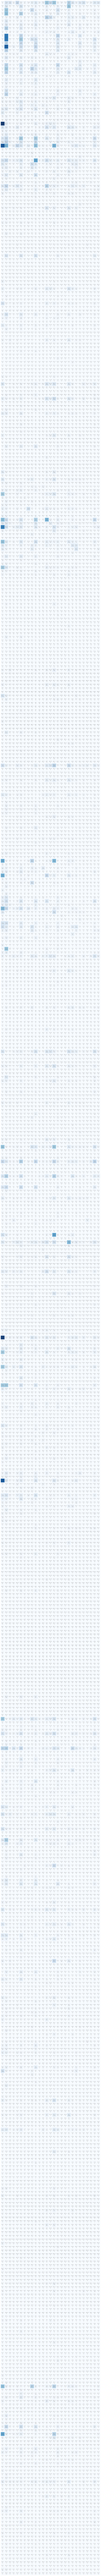

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(1  yrv, 420))
plt.imshow(N, cmap='Blues')
for i in range(702):
    for j in range(27):
        chstr = itodoublet[i+1] + ' ' + itos[j+1]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')